In [1]:
import os
from pysmiles import read_smiles
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from tqdm import tqdm

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader

# Load Data

In [2]:
train = pd.read_csv(os.path.join('..','data','train.csv'))
dev = pd.read_csv(os.path.join('..','data','dev.csv'))

In [3]:
train = pd.concat([train, dev])
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30345 entries, 0 to 70
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   uid            30345 non-null  object 
 1   SMILES         30345 non-null  object 
 2   S1_energy(eV)  30345 non-null  float64
 3   T1_energy(eV)  30345 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.2+ MB


In [110]:
!nvidia-smi

Wed Aug 25 05:36:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:1A:00.0 Off |                  N/A |
| 57%   49C    P2   120W / 370W |   3239MiB / 24268MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:68:00.0  On |                  N/A |
|  0%   

# The type of atom and the number of atom

## Unique atoms in total data

In [4]:
unique_char = set()
for smiles in train['SMILES']:
    mols = Chem.MolFromSmiles(smiles)
    num_atoms = mols.GetNumAtoms()
    for n in range(num_atoms) :
        type_atoms = mols.GetAtomWithIdx(n).GetSymbol()
        unique_char.add(type_atoms)
        
unique_char = sorted(list(unique_char))

In [5]:
unique_char

['B', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Si']

In [6]:
atom_token = {}
for atom in unique_char:
    atom_token[atom] = 0
print(atom_token)

{'B': 0, 'Br': 0, 'C': 0, 'Cl': 0, 'F': 0, 'H': 0, 'I': 0, 'N': 0, 'O': 0, 'P': 0, 'S': 0, 'Si': 0}


CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N


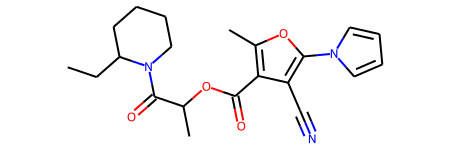

In [7]:
for smiles in train['SMILES']:
    print(smiles)
    break
m = Chem.MolFromSmiles(train['SMILES'].iloc[0])
m

In [8]:
m = Chem.MolFromSmiles(train['SMILES'].iloc[0])
rings = m.GetRingInfo().BondRings()

In [9]:
def isRingAromatic(mol, bondRing):
    for id in bondRing:
        if not mol.GetBondWithIdx(id).GetIsAromatic():
            return False
    return True
#print(isRingAromatic(m, ri.BondRings()[0]))

In [16]:
count_aroma = []
for ring in rings: 
    count_aroma.append(isRingAromatic(m, ring))    
count_aroma = sum(count_aroma)
count_aroma

2

## Convert SMILES to Token

In [17]:
def smiles2num(train):
    token_list = []
    for smiles in train['SMILES']:
        atom_token = {'B': 0, 'Br': 0, 'C': 0, 'Cl': 0, 'F': 0, 'H': 0, 'I': 0, 'N': 0, 'O': 0, 'P': 0, 'S': 0, 'Si': 0, 'Aromatic': 0}
        m = Chem.MolFromSmiles(smiles)
        num_atom = m.GetNumAtoms()
        for n in range(num_atom) :
            type_atom = m.GetAtomWithIdx(n).GetSymbol()
            atom_token[type_atom] += 1
        
        rings = m.GetRingInfo().BondRings()
        count_aroma = []
        for ring in rings: 
            count_aroma.append(isRingAromatic(m, ring))
        count_aroma = sum(count_aroma)
        atom_token['Aromatic'] = count_aroma
        token_list.append(atom_token)
    df_atom = pd.DataFrame.from_dict(token_list)
    return df_atom

In [18]:
df_atom = smiles2num(train)

In [19]:
df_atom

,B,Br,C,Cl,F,H,I,N,O,P,S,Si,Aromatic
0,0,0,21,0,0,0,0,3,4,0,0,0,2
1,0,0,33,1,0,0,0,4,3,0,1,0,5
2,0,0,19,0,0,0,0,3,3,0,1,0,2
3,0,0,13,0,0,0,0,2,1,0,1,0,1
4,0,0,14,0,3,0,0,1,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30340,0,0,44,0,0,0,0,4,2,0,0,0,7
30341,0,0,65,0,0,0,0,5,0,0,0,0,10
30342,2,0,68,0,0,0,0,2,0,0,0,0,10
30343,2,0,52,0,0,0,0,2,0,0,0,0,10


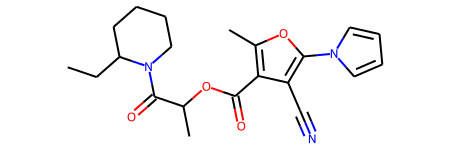

In [79]:
m = Chem.MolFromSmiles(train['SMILES'].iloc[0])
m

In [23]:
train.tail(5)

,uid,SMILES,S1_energy(eV),T1_energy(eV)
66,dev_66,N#Cc1cc(-c2ccc(N3c4ccccc4Oc4ccccc43)cc2)c(-c2c...,2.1939,2.1846
67,dev_67,CC1(C)c2ccccc2N(c2ccc(-c3nc4ccc(N5c6ccccc6C(C)...,2.3537,2.3371
68,dev_68,Cc1cc(-n2c3ccc(C(C)(C)C)cc3c3cc(C(C)(C)C)ccc32...,2.1364,2.1260
69,dev_69,Cc1cc(-n2c3ccccc3c3ccccc32)cc(C)c1B1c2ccccc2B(...,2.2650,2.2511
70,dev_70,CC(C)(C)c1ccc2c(c1)c1cc(C(C)(C)C)ccc1n2-c1c(Cl...,2.5477,2.4184


In [47]:
#df = pd.concat([train, df_atom], axis=1)

In [48]:
dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   uid            71 non-null     object 
 1   SMILES         71 non-null     object 
 2   S1_energy(eV)  71 non-null     float64
 3   T1_energy(eV)  71 non-null     float64
dtypes: float64(2), object(2)
memory usage: 2.3+ KB


# EDA

In [49]:
df = df_atom

In [50]:
df.shape

(30345, 13)

In [51]:
df.size

394485

In [52]:
df.ndim

2

In [53]:
df.describe()

,B,Br,C,Cl,F,H,I,N,O,P,S,Si,Aromatic
count,30345.000000,30345.000000,30345.000000,30345.000000,30345.000000,30345.000000,30345.000000,30345.000000,30345.000000,30345.000000,30345.000000,30345.000000,30345.000000
mean,0.018883,0.076026,18.832460,0.188103,0.389751,0.000033,0.011303,2.538903,2.403427,0.009128,0.354325,0.013445,2.105783
std,0.151904,0.304181,9.043091,0.500998,1.069732,0.005741,0.127996,1.614697,1.810667,0.114881,0.622707,0.171695,1.766456
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,2.000000
75%,0.000000,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,1.000000,0.000000,3.000000
max,3.000000,8.000000,140.000000,8.000000,26.000000,1.000000,8.000000,15.000000,22.000000,4.000000,8.000000,8.000000,26.000000


In [54]:
df.isnull( ).sum( )

B           0
Br          0
C           0
Cl          0
F           0
H           0
I           0
N           0
O           0
P           0
S           0
Si          0
Aromatic    0
dtype: int64

In [55]:
df.nunique( )

B             4
Br            7
C           111
Cl            8
F            20
H             2
I             6
N            14
O            22
P             5
S             9
Si            8
Aromatic     25
dtype: int64

In [56]:
df.index

RangeIndex(start=0, stop=30345, step=1)

In [57]:
df.columns

Index(['B', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Si',
       'Aromatic'],
      dtype='object')

In [58]:
df.memory_usage( )

Index          128
B           242760
Br          242760
C           242760
Cl          242760
F           242760
H           242760
I           242760
N           242760
O           242760
P           242760
S           242760
Si          242760
Aromatic    242760
dtype: int64

In [59]:
df.dropna( )

,B,Br,C,Cl,F,H,I,N,O,P,S,Si,Aromatic
0,0,0,21,0,0,0,0,3,4,0,0,0,2
1,0,0,33,1,0,0,0,4,3,0,1,0,5
2,0,0,19,0,0,0,0,3,3,0,1,0,2
3,0,0,13,0,0,0,0,2,1,0,1,0,1
4,0,0,14,0,3,0,0,1,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30340,0,0,44,0,0,0,0,4,2,0,0,0,7
30341,0,0,65,0,0,0,0,5,0,0,0,0,10
30342,2,0,68,0,0,0,0,2,0,0,0,0,10
30343,2,0,52,0,0,0,0,2,0,0,0,0,10


In [60]:
df.isna( )

,B,Br,C,Cl,F,H,I,N,O,P,S,Si,Aromatic
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30340,False,False,False,False,False,False,False,False,False,False,False,False,False
30341,False,False,False,False,False,False,False,False,False,False,False,False,False
30342,False,False,False,False,False,False,False,False,False,False,False,False,False
30343,False,False,False,False,False,False,False,False,False,False,False,False,False


In [61]:
df.corr()

,B,Br,C,Cl,F,H,I,N,O,P,S,Si,Aromatic
B,1.000000,0.002452,0.179474,-0.028486,0.178201,-0.000714,0.046651,-0.015961,-0.039679,0.010895,-0.032759,-0.008471,0.156515
Br,0.002452,1.000000,-0.073758,-0.007343,0.008087,-0.001435,-0.000065,-0.083888,-0.078726,-0.005714,-0.021997,-0.011370,-0.010000
C,0.179474,-0.073758,1.000000,-0.037073,0.058989,-0.009416,-0.007532,0.153239,0.134374,0.039792,0.003063,0.085821,0.794655
Cl,-0.028486,-0.007343,-0.037073,1.000000,-0.018368,-0.002155,0.000247,-0.025260,-0.027383,-0.014947,0.002801,-0.020974,0.021605
F,0.178201,0.008087,0.058989,-0.018368,1.000000,0.014008,0.007537,-0.014130,-0.062891,-0.006157,-0.026597,-0.005207,0.064875
H,-0.000714,-0.001435,-0.009416,-0.002155,0.014008,1.000000,-0.000507,-0.009027,-0.007620,-0.000456,-0.003267,-0.000450,-0.006844
I,0.046651,-0.000065,-0.007532,0.000247,0.007537,-0.000507,1.000000,-0.028677,-0.014842,-0.002535,-0.017173,-0.000917,0.009870
N,-0.015961,-0.083888,0.153239,-0.025260,-0.014130,-0.009027,-0.028677,1.000000,-0.066699,-0.045885,0.045647,-0.076538,0.244704
O,-0.039679,-0.078726,0.134374,-0.027383,-0.062891,-0.007620,-0.014842,-0.066699,1.000000,0.099534,0.073052,-0.012254,-0.065263
P,0.010895,-0.005714,0.039792,-0.014947,-0.006157,-0.000456,-0.002535,-0.045885,0.099534,1.000000,-0.009282,0.010485,0.039576


In [62]:
train['ST1_GAP(eV)'] = train['S1_energy(eV)'] - train['T1_energy(eV)']

In [63]:
df = pd.concat([df, train['ST1_GAP(eV)'].reset_index(drop=True)], axis=1)
df

,B,Br,C,Cl,F,H,I,N,O,P,S,Si,Aromatic,ST1_GAP(eV)
0,0,0,21,0,0,0,0,3,4,0,0,0,2,1.2938
1,0,0,33,1,0,0,0,4,3,0,1,0,5,0.2032
2,0,0,19,0,0,0,0,3,3,0,1,0,2,0.4633
3,0,0,13,0,0,0,0,2,1,0,1,0,1,1.1054
4,0,0,14,0,3,0,0,1,2,0,0,0,0,0.2243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30340,0,0,44,0,0,0,0,4,2,0,0,0,7,0.0093
30341,0,0,65,0,0,0,0,5,0,0,0,0,10,0.0166
30342,2,0,68,0,0,0,0,2,0,0,0,0,10,0.0104
30343,2,0,52,0,0,0,0,2,0,0,0,0,10,0.0139


In [64]:
from pandas_profiling import ProfileReport

In [65]:
#profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)

In [66]:
profile = ProfileReport(df, minimal=True)
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Learning

## Linear Regression

In [98]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [83]:
y_target = df['ST1_GAP(eV)']
X_data = df.drop(['H', 'ST1_GAP(eV)'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.3, random_state=156)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_preds)

print('MSE : {0:.3f}, RMSE : {1:.3F}, MAE : {2:3F}'.format(mse, rmse, mae))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 0.129, RMSE : 0.360, MAE : 0.285796
Variance score : 0.020


In [84]:
neg_mean_absolute_error = cross_val_score(lr, X_data, y_target, scoring='neg_mean_absolute_error', cv=5)
avg_mae = np.mean(neg_mean_absolute_error)
print(avg_mae)

-0.2921216815026569


## Lidge Regression

In [91]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10)
neg_mean_absolute_error = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_absolute_error', cv=5)
avg_mae = np.mean(neg_mean_absolute_error)
print(avg_mae)

-0.2921181042150723


In [92]:
alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    neg_mean_absolute_error = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_absolute_error', cv=5)
    avg_mae = np.mean(neg_mean_absolute_error)
    print(avg_mae)

-0.2921216815026569
-0.29212162471176867
-0.292121150292521
-0.2921181042150723
-0.29213498703251495


## Lasso Regression

In [96]:
from sklearn.linear_model import Lasso, ElasticNet

def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
    coeff_df = pd.DataFrame()
    if verbose: print('######', model_name, '######')
    for param in params:
        if model_name == 'Ridge':model = Ridge(alpha=param)
        elif model_name == 'Lasso':model = Lasso(alpha=param)
        elif model_name == 'ElasticNet':model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mean_absolute_error = cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_absolute_error', cv=5)
        avg_mae = np.mean(neg_mean_absolute_error) * -1
        print(avg_mae)
        model.fit(X_data, y_target)
        coeff = pd.Series(data=model.coef_, index=X_data.columns)
        colname = 'alpha'+str(param)
        coeff_df[colname] = coeff
    return coeff_df

In [97]:
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

###### Lasso ######
0.29248120643467324
0.29246738313847026
0.29251889915746465
0.29251889915746465
0.29251889915746465


## Random Forest

In [101]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(random_state=0)
neg_mean_absolute_error = cross_val_score(regr, X_data, y_target, scoring='neg_mean_absolute_error', cv=5)
avg_mae = np.mean(neg_mean_absolute_error)
print(avg_mae)

-0.2885264298963087


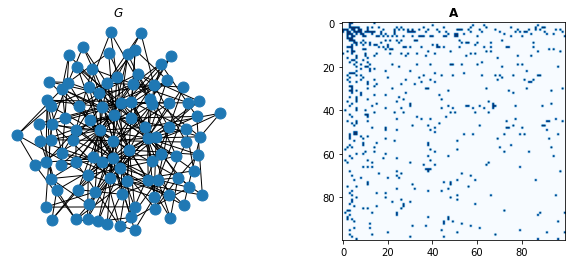

In [102]:
import networkx as nx 
import matplotlib.pyplot as plt 
G = nx.barabasi_albert_graph(100, 3) 
_, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 0.5}) 
nx.draw_kamada_kawai(G, ax=axes[0], node_size=120) 
axes[1].imshow(nx.to_numpy_matrix(G), aspect='auto', cmap='Blues') 
axes[0].set_title("$G$") 
axes[1].set_title("$\mathbf{A}$") 
plt.show()

In [103]:
G

In [105]:
import torch
mat = torch.arange(12).view(3, 4)
mat

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

In [106]:
mat[0]

tensor([0, 1, 2, 3])

In [107]:
mat[:, -1]

tensor([ 3,  7, 11])

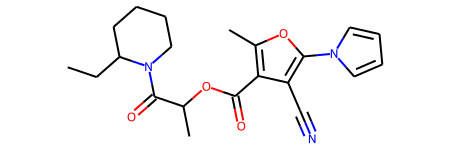